##  Objective

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

In [29]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
#using Sqlite3 to connect to the database file
conn = sqlite3.connect('database.sqlite')

#Filtering Data where only positive and negative reviews come in and discarding the reviews with neutral score
filtered_data = pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3''', conn)

#Given reviews with score > 3 a positive rating, and reviews with a score<3 with a negative rating
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

#changing review score less than 3 to be negative and vice-versa
actialScore = filtered_data['Score']
positiveNegative = actialScore.map(partition)
filtered_data['Score'] = positiveNegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [24]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


The filtered data has 525814 observations, and there is no missing value in it.

In [25]:
# check duplicated entries and drop them

dup = filtered_data[filtered_data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
print(dup.shape)

df = filtered_data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(215164, 10)


(364173, 10)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364173 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      364173 non-null  int64 
 1   ProductId               364173 non-null  object
 2   UserId                  364173 non-null  object
 3   ProfileName             364173 non-null  object
 4   HelpfulnessNumerator    364173 non-null  int64 
 5   HelpfulnessDenominator  364173 non-null  int64 
 6   Score                   364173 non-null  object
 7   Time                    364173 non-null  int64 
 8   Summary                 364173 non-null  object
 9   Text                    364173 non-null  object
dtypes: int64(4), object(6)
memory usage: 30.6+ MB


### Analysis reveiew over time

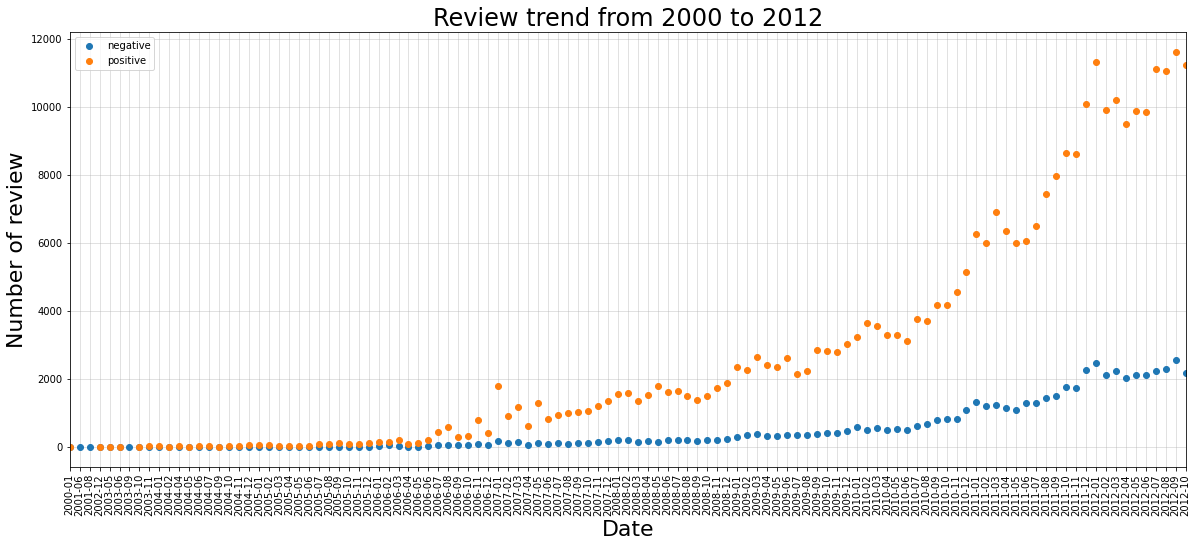

In [27]:
df['date'] = pd.to_datetime(df['Time'],unit='s')
dff = df[['date','Text','Score']]
dff.date = df.date.dt.strftime('%Y-%m')
# dff['date'] = dff['date'].dt.to_timestamp()
dff = dff.sort_values(by=['date']).reset_index(drop=True)
dff_neg = dff[dff['Score'] == 'negative']
dff_pos = dff[dff['Score'] == 'positive']

dff_neg = dff_neg.groupby('date')['Score'].count().reset_index()
dff_pos = dff_pos.groupby('date')['Score'].count().reset_index()


plt.figure(figsize=(20,8))

plt.plot_date(x=dff_neg['date'],y=dff_neg['Score'],label='negative')
plt.plot_date(x=dff_pos['date'],y=dff_pos['Score'],label='positive')

plt.grid(linewidth=0.5,alpha=0.75)
plt.xticks(rotation=90)
plt.xlim('2000-01','2012-10')
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012',fontsize=24)
plt.savefig('review_trend.png')
plt.legend()
plt.show()

From 2000 to 2006 the number of reviews is consistent. But after that, the number of reviews began to increase. The reason can be the popularity of internet and the increase in the number of user accounts. What's more, the number of negative reviews were high. Maybe that are unverified accounts boosting the seller inappropriately with fake reviews. 


### Analysis on label

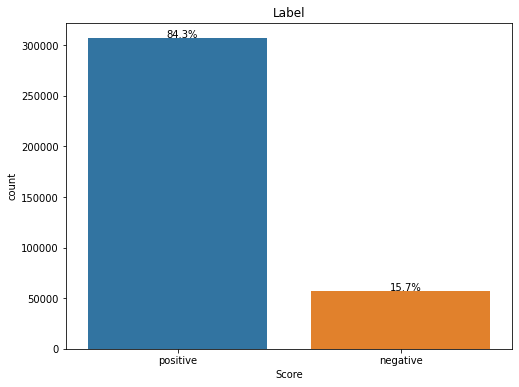

In [78]:
plt.figure(figsize=(8,6))
ax=sns.countplot('Score', data=df)
plt.title('Label')

for p in ax.patches:
   ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.35, p.get_height()+500))

plt.show()

There is unbalance issue. So  we will use AUC(Area under ROC curve) as evaluation metrics.

### Analysis On ProductId and UserId

In [87]:
purchases = df[['ProductId','UserId']].groupby('UserId').agg({'ProductId': ['count']})
purchases.columns = ['No_of_products_purchased']
purchases = purchases.reset_index()
purchases.head(5)

,UserId,No_of_products_purchased
0,#oc-R103C0QSV1DF5E,1
1,#oc-R109MU5OBBZ59U,1
2,#oc-R10LFEMQEW6QGZ,1
3,#oc-R10UA029WVWIUI,1
4,#oc-R115TNMSPFT9I7,1


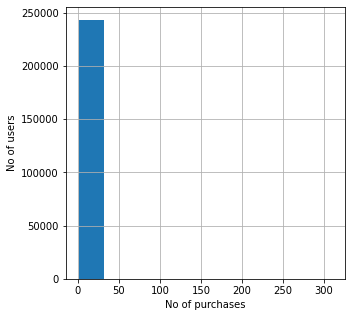

count    243414.000000
mean          1.496105
std           2.537897
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         310.000000
Name: No_of_products_purchased, dtype: float64


In [90]:
plt.figure(figsize=(5,5))
purchases['No_of_products_purchased'].hist()
plt.xlabel('No of purchases')
plt.ylabel('No of users')
plt.show()
print(purchases['No_of_products_purchased'].describe())

After analyzing the no of products that the user brought, we came to know that most of the users have brought a single product.

In [96]:
# extract text data and save it for preprocessing
data=df[['Score', 'Time', 'Summary', 'Text']]
data.to_csv('data.csv', index=False)